<h1>Discharge Recurrence Intervals</h1>

Using <a href="https://www.bafg.de/GRDC/EN/01_GRDC/13_dtbse/database_node.html">GRDC</a> data for Madagascar rivers to estimate the duration of 2-year recurrence bankfull discharge events, which serve as a basis for estimating $t_{scour}$, saved to <strong>./discharge_data/compilations/*.csv</strong>).

In [1]:
__author__ = "Sam Brooke"
__email__ = "sbrooke@ucsb.edu"

import os
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy as sp
import scipy.stats as st
import pandas as pd
from datetime import datetime
from dateutil import relativedelta
import csv
from scipy import stats, interpolate
from calendar import monthrange

os.makedirs('./discharge_data/compilations', exist_ok=True)

plot_charts = True

def discharge_time_series(files, prefix, sampling, source, madagascar=False):
    
    # Parsing the GRDC data files.
    
    discharge_outputs = {}
    for df in files:
        with open(df, "rb") as f:

            dates = []
            date_strings = []
            discharge = []
            begin_data = False
            
            for lidx, line in enumerate(f):

                if line[0:6].strip().decode("utf-8") == '# DATA':
                     begin_data = lidx+2
                     continue

                if not begin_data:
                    if lidx == 9:
                        RIVER = line[25:].strip().decode("utf-8")

                    if lidx == 10:
                        STATION = line[25:].strip().decode("utf-8")
                else:
                    if lidx >= begin_data:
                        dt_str = line[0:10].decode("utf-8")
                        dates.append(datetime.strptime(dt_str, "%Y-%m-%d"))
                        date_strings.append(dt_str)
                        ln_split = line.decode("utf-8").split(';')
                        discharge.append(float(ln_split[2].strip()))


        time_series_csv = os.path.join('./discharge_data/timeseries/', prefix+'_'+RIVER.replace(' ', '_')+'.csv')

        with open(time_series_csv, 'w') as ts_f:
            ts_f.write('DATE, DISCHARGE'+"\n")
            
            for didx, dis in enumerate(discharge):
                ts_f.write(date_strings[didx]+" , "+str(dis)+"\n")
                
        discharge_outputs[prefix+'_'+RIVER.replace(' ', '_')] = {
            'discharge':discharge,
            'date':dates,
            'river_key':RIVER.replace(' ', '_'),
            'sampling': sampling,
            'source': source
        }
        
        if madagascar:
            discharge_outputs[prefix+'_'+RIVER.replace(' ', '_')]['madagascar'] = 'yes'
        else:
            discharge_outputs[prefix+'_'+RIVER.replace(' ', '_')]['madagascar'] = 'no'

    return discharge_outputs


def flood_Qbf(pickles):
    
    # Get all the data saved in a regular format in the pickle files.
    
    def Merge(dict1, dict2):
        res = {**dict1, **dict2}
        return res

    discharge_data = {}

    for p in pickles:
        if p != 'rivdis_time_series_monthly.pkl':
            pkl_file = open(p, 'rb')
            input_date = pickle.load(pkl_file)
            discharge_data = Merge(discharge_data, input_date)
            pkl_file.close()
    
    qbf_dict = {}
    
    for key in discharge_data.keys():
        
        dat = discharge_data[key]
        dis = np.array(dat['discharge'])

        dis[dis<0] = np.NaN
        dates = dat['date']
        ts = pd.DataFrame(list(zip(dates, dis)), columns=['date', 'discharge'])
        ts = ts.set_index(pd.DatetimeIndex(ts['date']))
        ts['year'] = ts.index.year
        ts = ts.groupby([ts.index.year]).max() # Convert to yearly maximum discharge
        
        qbf_dict[dat['river_key']] = ts.discharge.median()
                
    return qbf_dict


def flood_durations(pickles, output_file):
    
    estimated_Qbf = flood_Qbf(pickles)
        
    def Merge(dict1, dict2):
        res = {**dict1, **dict2}
        return res

    discharge_data = {}

    for p in pickles:
        pkl_file = open(p, 'rb')
        input_date = pickle.load(pkl_file)
        discharge_data = Merge(discharge_data, input_date)
        pkl_file.close()

    fig_width_cm = 25                             # A4 page
    fig_height_cm = 18
    inches_per_cm = 1 / 2.54                         # Convert cm to inches
    fig_width = fig_width_cm * inches_per_cm         # width in inches
    fig_height = fig_height_cm * inches_per_cm       # height in inches
    fig_size = [fig_width, fig_height]

    # Most lifted from Jerolmack and Mohrig 2007
    # False is a reported Qbf value is missing and we use 2-year flood
    recorded_Qbfs = { # m3/s
        "PARANA,_RIO": 16000,  # Jerolmack and Mohrig 2007
        "MISSISSIPPI_RIVER": 25000,  # Jerolmack and Mohrig 2007
        "DANUBE_RIVER": 9700,  # Chatanantavet et al., 2012
        "BRAHMAPUTRA_RIVER": 35000,  # Jerolmack and Mohrig 2007
        "RHINE_RIVER": 3500,  # Jerolmack and Mohrig 2007
        "AMAZON_RIVER": 200000,  # Average of discharge measurements at Obidos (Oltman, 1968)
        "RHONE": 2100, # Jerolmack and Mohrig 2007
        "ORINOCO,_RIO": 38000,  # Jerolmack and Mohrig 2007
        "ASSINIBOINE_RIVER": False,  # Jerolmack and Mohrig 2007
        "YELLOW_RIVER": 3000,  # Jerolmack and Mohrig 2007 (aka Huanghe)
        "NILE_RIVER": 8800, # Chatanantavet et al., 2012
        "MAGDALENA,_RIO": 8800, # Jerolmack and Mohrig 2007
        "SAMBIRANO": False,
        'MANAMBOLO': False,
        'MANANARA':False,
        'MANGOKY': False,
        'SOFIA': False,
        'MANDRARE': False,
        'LINTA': False,
        'VOHITRA': False,
        'MORONDAVA': False,
        'IAROKA': False,
        'MANIA': False,
        'MAHAVAVY': False,
        'MENARANDRA': False,
        'BEMARIVO': False,
        'BETSIBOKA': False,
        'IVONDRO': False,
        'TSIRIBIHINA': False
    }

    madagascar_rivers = ['MANAMBOLO', 'MANGOKY', 'MORONDAVA', 'MANIA', 'MAHAVAVY', 'BETSIBOKA']

    datarows = []
    all_durations = [] # For capturing the complete distrubtion of Madagascar river flood durations
    
    for key in discharge_data.keys():

        dat = discharge_data[key]
                
        if dat['river_key'] not in estimated_Qbf.keys():
            continue

        dis = np.array(dat['discharge'])
        dis[dis<=0] = np.NaN
        dates = dat['date']
        ts = pd.Series(dis, dates)
        max_dis = ts.groupby([ts.index.year]).max()

        yearly_maximums = []
        yearly_dates = []
        for items in max_dis.iteritems():
            year_start = datetime(items[0], 1, 1)
            year_end = datetime(items[0], 12, 31)

            if items[1] > 0:
                yearly_maximums.append(items[1])
                yearly_maximums.append(items[1])
                yearly_dates.append(year_start)
                yearly_dates.append(year_end)

        reported_max_discharge = recorded_Qbfs[dat['river_key']]
        estimated_max_discharge = estimated_Qbf[dat['river_key']]
   
        print('River '+dat['river_key'])
        
        print('Estimated Discharge: '+str(estimated_Qbf[dat['river_key']]))
        print('Reported Discharge: '+str(recorded_Qbfs[dat['river_key']]))
        
        # Is there a recorded Qbf or are we using an estimate?
        if not recorded_Qbfs[dat['river_key']]:
            max_discharge = estimated_Qbf[dat['river_key']]
            flood_type = 'Estimated'
        else:
            max_discharge = recorded_Qbfs[dat['river_key']]
            flood_type = 'Reported'
        
            
        ts = ts[~ts.index.duplicated()]
        max_floods = ts.copy()
        max_floods[ts <= max_discharge] = np.NaN # Clip anything under flood Qbf

        max_flood_dist = {
            'date':max_floods.index,
            'year':max_floods.index.year,
            'discharge':max_floods.values,
            'river':dat['river_key']
        }

        df_flood = pd.DataFrame(max_flood_dist)
        
        flood_occurence = []
        years = list(np.unique(ts.index.year))

        for y in years:
            mask = df_flood['year'] == y
            if df_flood.loc[mask]['discharge'].sum() > 0:
                flood_occurence.append(1)
            else:
                flood_occurence.append(0)

        if sum(flood_occurence) <= 0:
            print(key+' has no floods!')
            continue

        flood_occurence = round(len(flood_occurence)/sum(flood_occurence), 2)
        
        active_flood = False
        active_flood_levels = []
        flood_durations = []
        
        # Iterate through all the rows and count how many floods there are
        for index, row in df_flood.iterrows():
            if index > 0:
                previous_row = df_flood.iloc[index-1,:]
                if np.isnan(row['discharge']):
                    if active_flood:
                        previous_row = df_flood.iloc[index-1,:]
                        flood_durations.append([active_flood, previous_row['date'], active_flood_levels, row['river']])
                        active_flood = False
                        active_flood_levels = []
                else:
                    if not active_flood:
                        active_flood = previous_row['date']

                    active_flood_levels.append(row['discharge'])

        flood_start = []
        flood_end = []
        
        flood_means = []
        flood_maxs = []
        month_durations = []
        day_durations = []
        river_list = []

        for f in flood_durations:
            date_delta = f[1]-f[0]
            days_delta = date_delta / np.timedelta64(1, 'D') # How many days is our flood?
            #days_delta = date_delta.astype('timedelta64[D]') / np.timedelta64(1, 'D')
            flood_means.append(np.mean(f[2])) # Average flood
            flood_maxs.append(np.max(f[2])) # Max flood 
            flood_start.append(pd.to_datetime(str(f[0])).strftime("%d-%m-%Y"))
            flood_end.append(pd.to_datetime(str(f[1])).strftime("%d-%m-%Y"))
            month_durations.append(days_delta/float(30)) # Divide by a month (assume 30 days)
            day_durations.append(days_delta)
            river_list.append(row['river'])

        flood_duration_dict = {
            'Flood start':flood_start,
            'Flood end':flood_end,
            'Days':day_durations,
            'Mean discharge (cms)':flood_means,
            'Max discharge (cms)':flood_maxs
        }

        pd.DataFrame(flood_duration_dict).to_csv('./discharge_data/'+key.replace(',','')+'_flood_durations.csv')
                          
        all_durations = all_durations+month_durations
        
        flood_duration_mean = round(np.mean(month_durations), 2) # T scour
        flood_duration_stdev = round(np.std(month_durations), 2) # T scour standard deviation

        discharge = df_flood['discharge'][~np.isnan(df_flood['discharge'])]
        flood_magnitude_mean = round(np.mean(discharge), 2)
        flood_magnitude_max = round(np.max(discharge), 2)
        flood_magnitude_stdev = round(np.std(discharge), 2)
        
        
        flood_n = len(flood_durations)
        flood_duration_standard_error = round(flood_duration_stdev/np.sqrt(flood_n), 2) # T scour standard error
        
        datarows.append([dat['river_key'], dat['sampling'], dat['source'], dat['madagascar'], round(estimated_max_discharge), reported_max_discharge, 
                         flood_type, flood_magnitude_mean, flood_magnitude_max,
            flood_magnitude_stdev, flood_duration_mean, flood_duration_stdev, flood_duration_standard_error, flood_n])
    
        if plot_charts:
            
            fig, ax = plt.subplots()
            fig.set_size_inches(fig_size)
            ax.step(ts.index, ts.values, linewidth=1)
            ax.step([dates[0],dates[-1]], [max_discharge, max_discharge], color='gray', linewidth=3)
            for idx, fs in enumerate(flood_start):
                dt1 = datetime.strptime(fs, "%d-%m-%Y")
                dt2 = datetime.strptime(flood_end[idx], "%d-%m-%Y")
                ax.plot([dt1, dt2], [max_discharge, max_discharge], '-', color='red', linewidth=10)

            # ax.plot(peak_dates, dis[peaks], "x")

            ax.text(0.05, 0.95,str(key), ha='left', va='top', transform=ax.transAxes, fontsize=12)
            ax.text(0.05, 0.85,'Recurrence: '+str(flood_occurence), ha='left', va='top', transform=ax.transAxes, fontsize=12)
            #ax.plot(max_floods.index, max_floods.values, color='green', linewidth=2)
            plt.tight_layout()
            ax.grid(True)
            leg_lines = ax.get_lines()
            # bulk-set the properties of all lines and texts
            plt.setp(leg_lines, linewidth=1)
            plt.savefig(os.path.join(output_dir, key.replace(',','')+'_PEAKS.pdf'),
                        dpi=300,
                        orientation='landscape')
        

    with open(output_file, mode='a+') as duration_file:
        wrt = csv.writer(duration_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for d in datarows:
            wrt.writerow(d)
    


<h2>Global Rivers</h2>

DAILY DATA
-----
River ORINOCO,_RIO
Estimated Discharge: 68640.0
Reported Discharge: 38000
River PARANA,_RIO
Estimated Discharge: 21896.0
Reported Discharge: 16000
River BRAHMAPUTRA_RIVER
Estimated Discharge: 67200.0
Reported Discharge: 35000
River RHONE
Estimated Discharge: 4660.0
Reported Discharge: 2100
River DANUBE_RIVER
Estimated Discharge: 10700.0
Reported Discharge: 9700
River MISSISSIPPI_RIVER
Estimated Discharge: 38227.742
Reported Discharge: 25000
River AMAZON_RIVER
Estimated Discharge: 237100.0
Reported Discharge: 200000
River RHINE_RIVER
Estimated Discharge: 6297.0
Reported Discharge: 3500
River ASSINIBOINE_RIVER
Estimated Discharge: 190.0
Reported Discharge: False

MONTHLY DATA
-----
River ASSINIBOINE_RIVER
Estimated Discharge: 94.5
Reported Discharge: False
River NILE_RIVER
Estimated Discharge: 8796.0
Reported Discharge: 8800
River BETSIBOKA
Estimated Discharge: 640.0
Reported Discharge: False
River MANGOKY
Estimated Discharge: 1522.0
Reported Discharge: False
River RHONE

<ipython-input-1-689712467c82>:321: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


River BRAHMAPUTRA_RIVER
Estimated Discharge: 52760.0
Reported Discharge: 35000
River RHINE_RIVER
Estimated Discharge: 3949.5
Reported Discharge: 3500
River YELLOW_RIVER
Estimated Discharge: 2560.447509765625
Reported Discharge: 3000


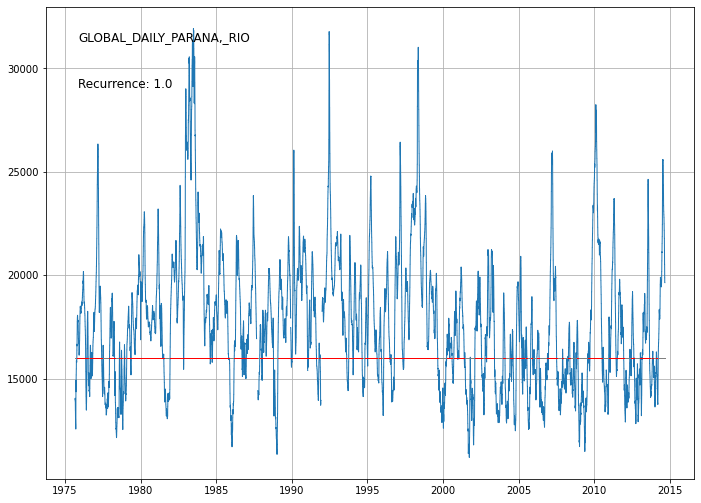

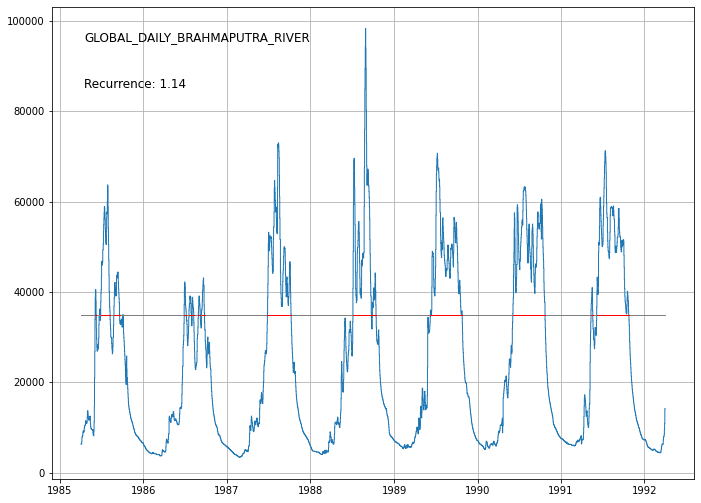

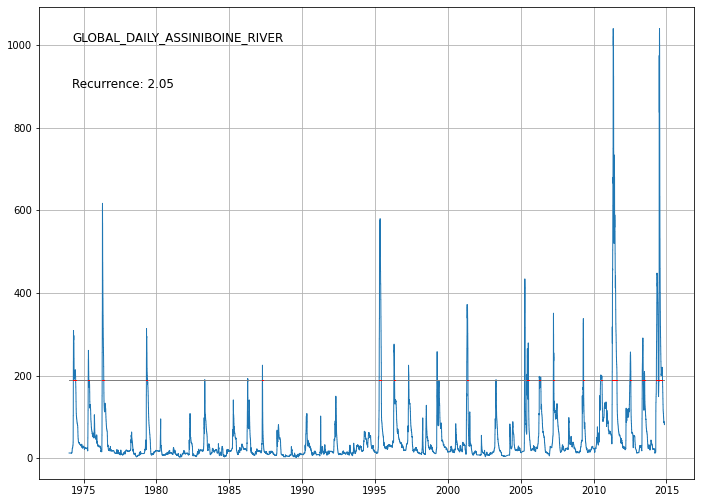

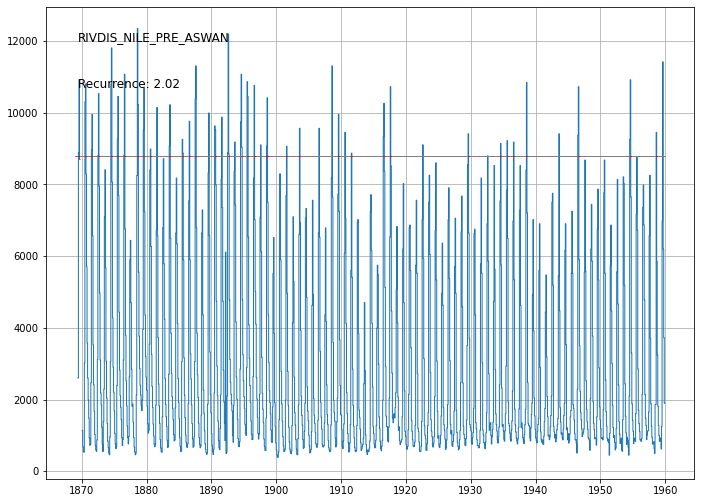

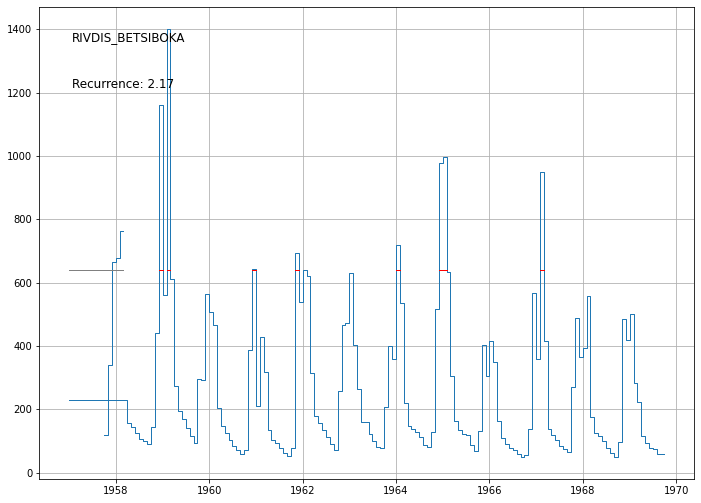

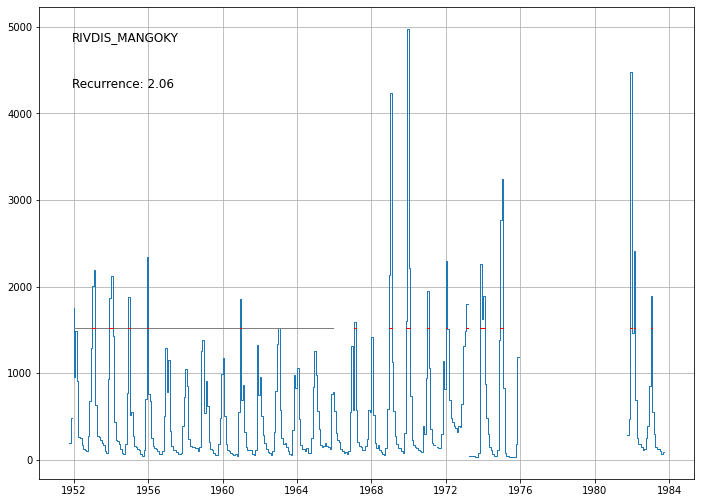

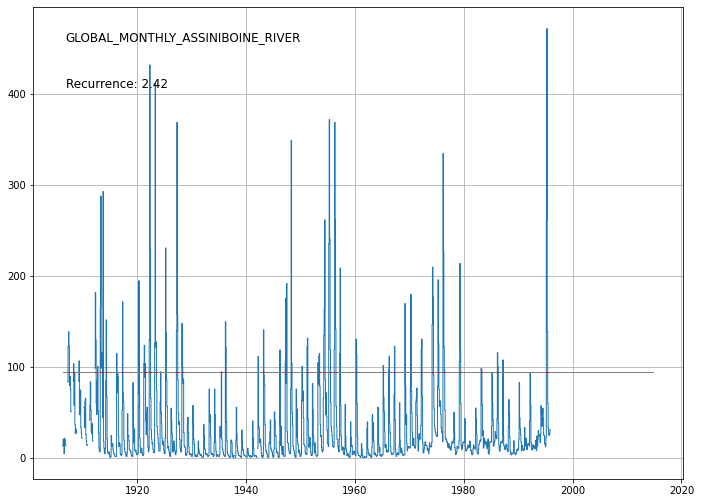

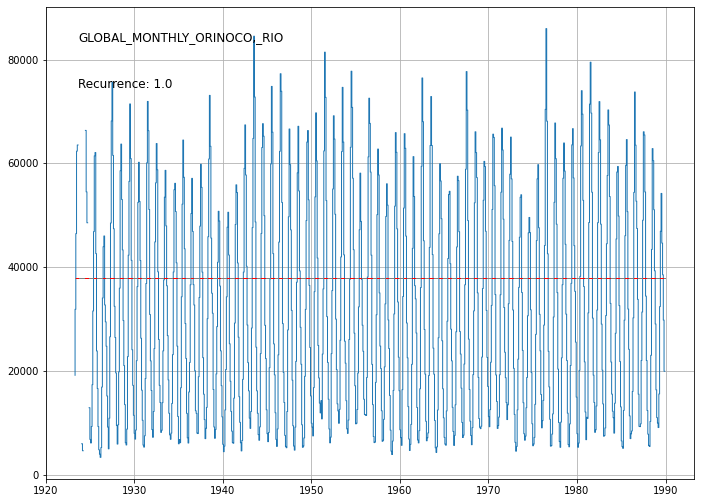

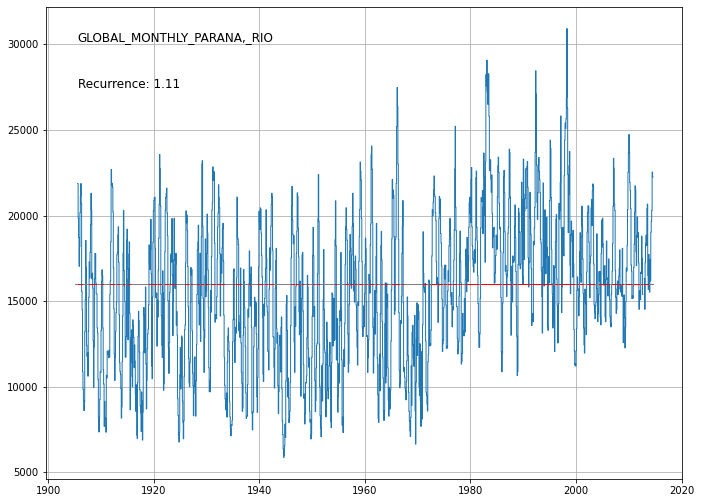

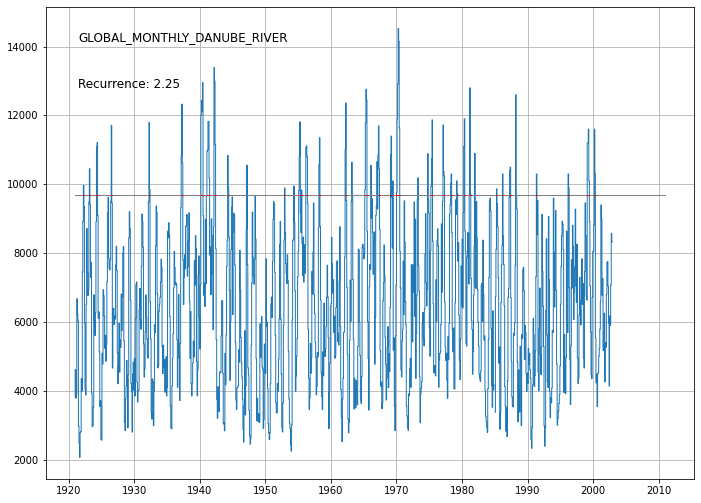

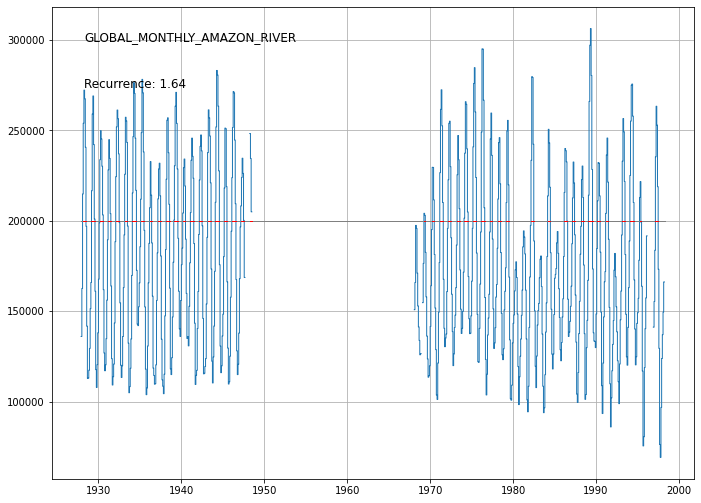

In [2]:
# GRDC
day_files = glob('./discharge_data/global_day_only/*.txt')
discharge_data = discharge_time_series(day_files, 'GLOBAL_DAILY', 'DAILY', 'GRDC')
output = open('./discharge_data/discharge_time_series_daily.pkl', 'wb')
pickle.dump(discharge_data, output)
output.close()

monthly_files = glob('./discharge_data/global_month_only/*.txt')
discharge_data = discharge_time_series(monthly_files, 'GLOBAL_MONTHLY', 'MONTHLY', 'GRDC')
output = open('./discharge_data/discharge_time_series_monthly.pkl', 'wb')
pickle.dump(discharge_data, output)
output.close()

madagascar_rivers = ['MANGOKY', 'BETSIBOKA']

# RIVDIS
rivdis_files = glob('./discharge_data/rivdis_data/*.csv')
rivdis_data = {}
for rdf in rivdis_files:
    river_name = os.path.basename(rdf)[:-4]
    rivdata = pd.read_csv(rdf)
    #rivdata['date'] = pd.to_datetime(rivdata['date'])
    rivdata['date'] = [datetime.strptime(date, "%Y-%m-%d %H:%M:%S") for date in rivdata['date']]
    if river_name in madagascar_rivers:

        rivdis_data['RIVDIS_'+river_name] = {
            'discharge':np.array(rivdata['discharge'].astype(np.float32)),
            'river_key':river_name,
            'date':list(rivdata['date']),
            'sampling': 'MONTHLY',
            'madagascar':'yes',
            'source': "RivDIS"
        }
    elif river_name=='NILE_PRE_ASWAN':
        rivdis_data['RIVDIS_'+river_name] = {
            'discharge':np.array(rivdata['discharge'].astype(np.float32)),
            'date':list(rivdata['date']),
            'river_key':'NILE_RIVER',
            'sampling': 'MONTHLY',
            'madagascar':'no',
            'source': "RivDIS"
        }
    else:
        rivdis_data['RIVDIS_'+river_name] = {
            'discharge':np.array(rivdata['discharge'].astype(np.float32)),
            'date':list(rivdata['date']),
            'river_key':river_name+'_RIVER',
            'sampling': 'MONTHLY',
            'madagascar':'no',
            'source': "RivDIS"
        }

output = open('./discharge_data/rivdis_time_series_monthly.pkl', 'wb')
pickle.dump(rivdis_data, output)
output.close()

print('DAILY DATA')
print('-----')


huanghe_data = {}
Huanghe_monthly_discharge = './discharge_data/huanghe_monthly/Huanghe_monthly_discharge.csv'
with open(Huanghe_monthly_discharge) as huanghe:
    reader = csv.reader(huanghe, delimiter=',', quotechar='|')
    dates = []
    discharge = []
    for c,row in enumerate(reader):
        if c > 0:
            for m in range(1,13):
                dt = datetime(int(row[0]), int(m), 1)
                dates.append(dt)
                discharge.append(float(row[m]))

        huanghe_data['YELLOW'] = {
            'discharge':np.array(discharge).astype(np.float32),
            'date':list(dates),
            'river_key':'YELLOW_RIVER',
            'sampling': 'MONTHLY',
            'madagascar':'no',
            'source': 'Ganti_2014'
        }

output = open('./discharge_data/Huanghe_monthly_discharge.pkl', 'wb')
pickle.dump(huanghe_data, output)
output.close()


# Output figure directory
output_dir = './discharge_plots'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_compilation = './discharge_data/compilations/COMPILATION_flood_Qbf_Global_Daily.csv'

if os.path.exists(output_compilation):
    os.remove(output_compilation)

os.makedirs('./discharge_data/timeseries', exist_ok=True)

with open(output_compilation, mode='w') as duration_file:
    wrt = csv.writer(duration_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    wrt.writerow(['River', 'Data', 'Source', 'Madagascar', 'Qbf - Estimated (cms)', 'Qbf - Reported (cms)',
                  'Qbf Choice', 'Average Flood Qbf (cms)', 'Max Flood Qbf (cms)',
                'Flood Qbf st.dev', 'Tscour (months)', 'Tscour st.dev',
                 'Tscour std. err.',  'Flood count'])
    
flood_durations(['./discharge_data/discharge_time_series_daily.pkl'], output_compilation)

print('')
print('MONTHLY DATA')
print('-----')

output_compilation = './discharge_data/compilations/COMPILATION_flood_Qbf_Global_Monthly.csv'

if os.path.exists(output_compilation):
    os.remove(output_compilation)

os.makedirs('./discharge_data/timeseries', exist_ok=True)

with open(output_compilation, mode='w') as duration_file:
    wrt = csv.writer(duration_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    wrt.writerow(['River', 'Data', 'Source', 'Madagascar', 'Qbf - Estimated (cms)', 'Qbf - Reported (cms)',
                  'Qbf Choice', 'Average Flood Qbf (cms)', 'Max Flood Qbf (cms)',
                'Flood Qbf st.dev', 'Tscour (months)', 'Tscour st.dev',
                 'Tscour std. err.',  'Flood count'])
    
flood_durations(['./discharge_data/rivdis_time_series_monthly.pkl',
                 './discharge_data/discharge_time_series_monthly.pkl',
                './discharge_data/Huanghe_monthly_discharge.pkl'], output_compilation)



<h2>Madagascar Rivers</h2>

River IAROKA
Estimated Discharge: 250.0
Reported Discharge: False
River MAHAVAVY
Estimated Discharge: 380.5
Reported Discharge: False
River MANGOKY
Estimated Discharge: 1495.0
Reported Discharge: False
River VOHITRA
Estimated Discharge: 126.5
Reported Discharge: False
River MANIA
Estimated Discharge: 1075.0
Reported Discharge: False
River BEMARIVO
Estimated Discharge: 1291.0
Reported Discharge: False
River MENARANDRA
Estimated Discharge: 135.0
Reported Discharge: False
River MANANARA
Estimated Discharge: 633.0
Reported Discharge: False
River SAMBIRANO
Estimated Discharge: 351.0
Reported Discharge: False
River MORONDAVA
Estimated Discharge: 168.0
Reported Discharge: False
River LINTA
Estimated Discharge: 23.0
Reported Discharge: False
River MANAMBOLO
Estimated Discharge: 271.0
Reported Discharge: False
River BETSIBOKA
Estimated Discharge: 640.0
Reported Discharge: False
River MANDRARE
Estimated Discharge: 263.0
Reported Discharge: False
River SOFIA
Estimated Discharge: 130.0
Reported Di

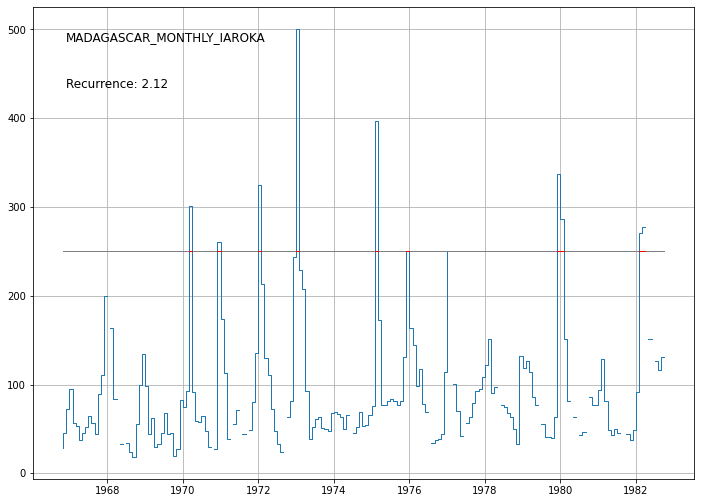

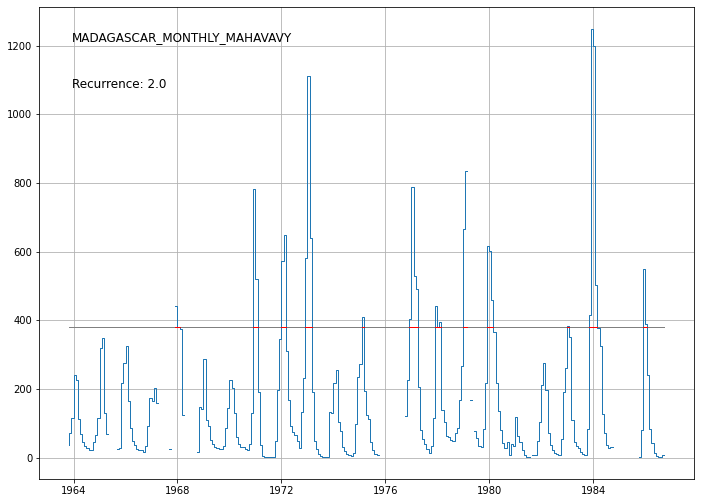

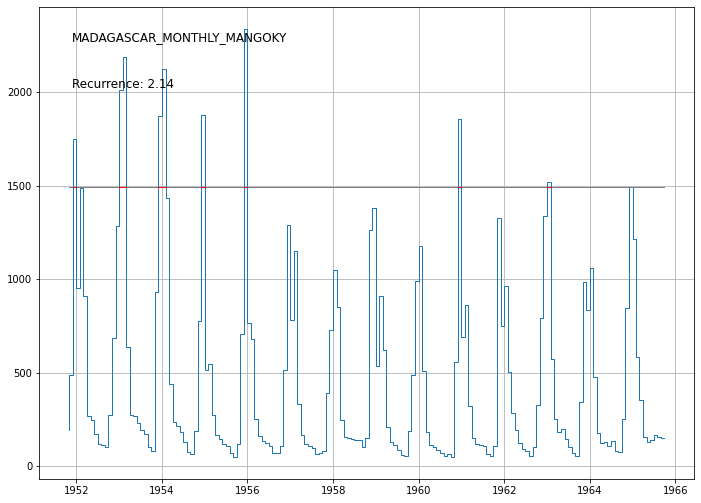

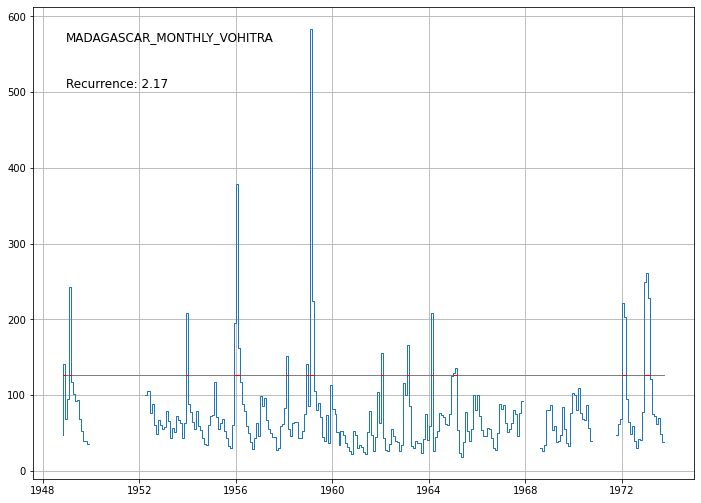

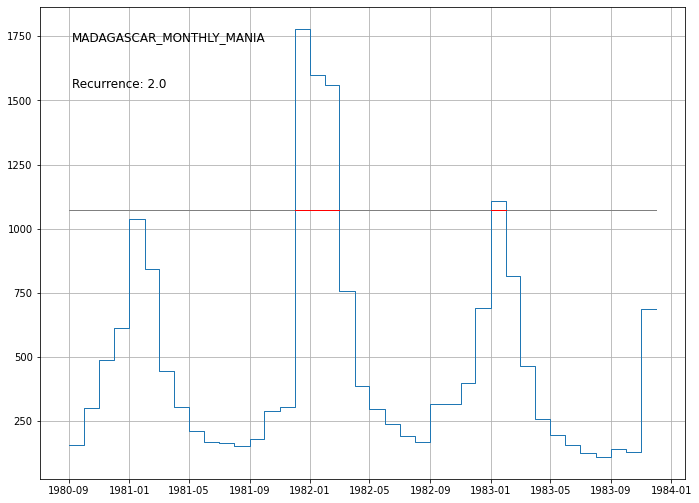

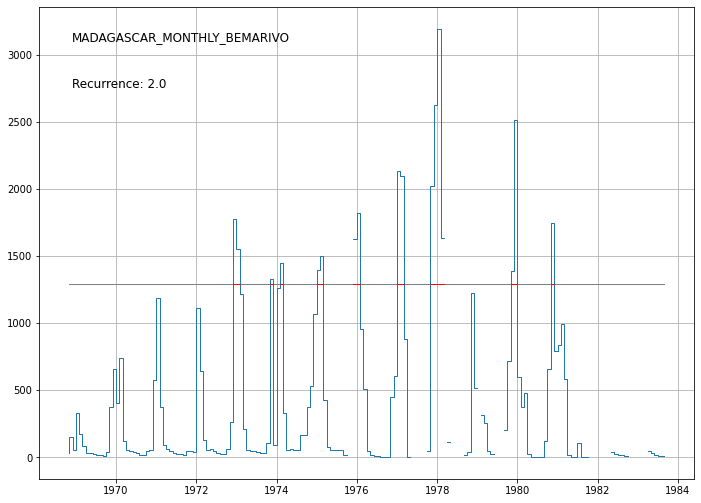

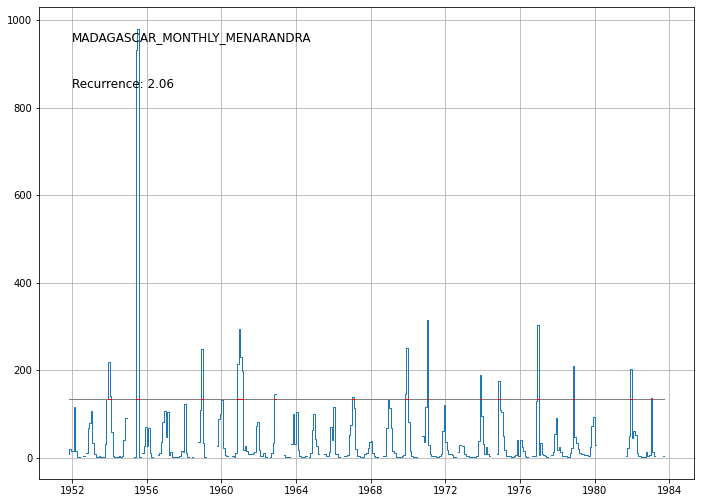

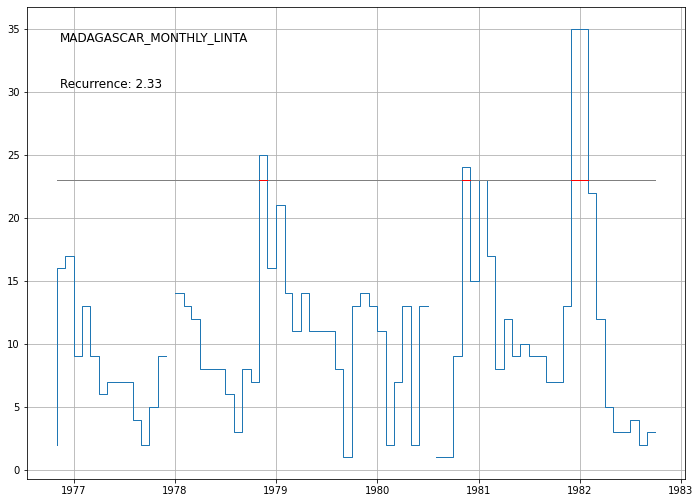

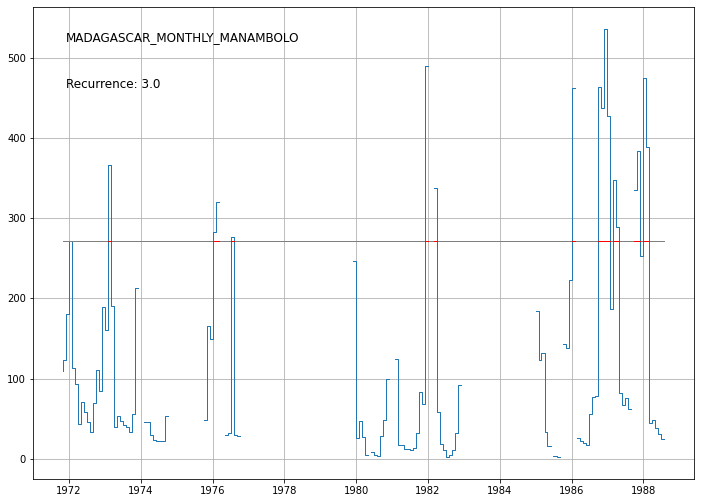

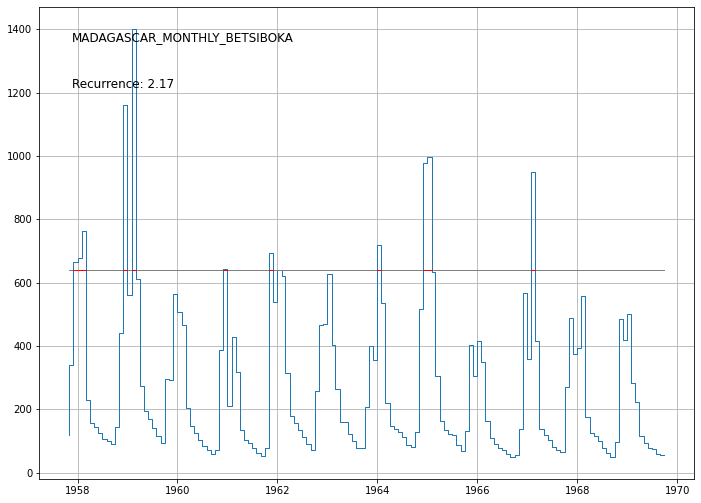

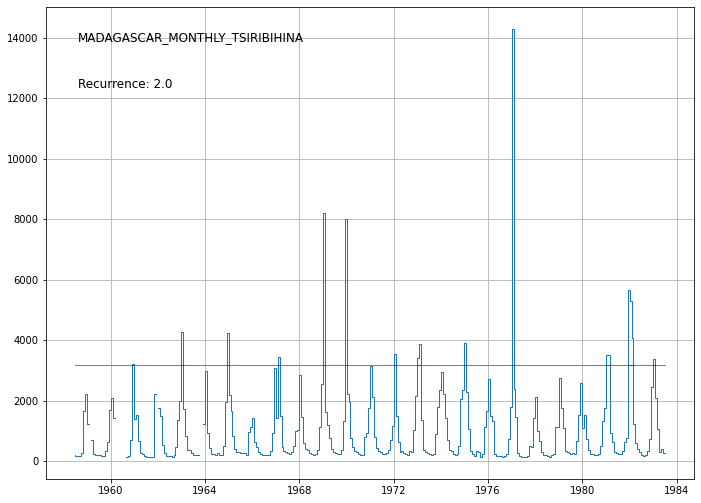

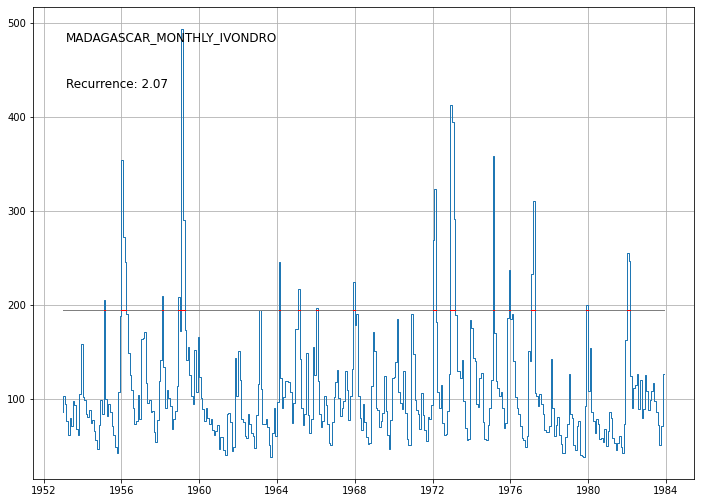

In [3]:
output_compilation = './discharge_data/compilations/COMPILATION_flood_Qbf_Madagascar.csv'

if os.path.exists(output_compilation):
    os.remove(output_compilation)

os.makedirs('./discharge_data/timeseries', exist_ok=True)

with open(output_compilation, mode='w') as duration_file:
    wrt = csv.writer(duration_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    wrt.writerow(['River', 'Data', 'Source', 'Madagascar', 'Qbf - Estimated (cms)', 'Qbf - Reported (cms)',
                  'Qbf Choice', 'Average Flood Qbf (cms)', 'Max Flood Qbf (cms)',
                'Flood Qbf st.dev', 'Tscour (months)', 'Tscour st.dev',
                 'Tscour std. err.',  'Flood count'])
        
        
if os.path.exists('./discharge_data/madagascar_time_series_monthly.pkl'):
    os.remove('./discharge_data/madagascar_time_series_monthly.pkl')

# GRDC
madagascar_files = glob('./discharge_data/GRDC_madagascar_monthly/*.txt')
discharge_data = discharge_time_series(madagascar_files, 'MADAGASCAR_MONTHLY', 'MONTHLY', 'GRDC', madagascar=True)
output = open('./discharge_data/madagascar_time_series_monthly.pkl', 'wb')
pickle.dump(discharge_data, output)
output.close()

# Output figure directory
output_dir = './discharge_plots'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Madagascar flood durations
flood_durations(['./discharge_data/madagascar_time_series_monthly.pkl'], output_compilation)
